<a href="https://colab.research.google.com/github/hyejeong1111/Transfer-learning/blob/main/%EC%B9%98%EB%A7%A4%EC%99%80%EC%A0%95%EC%83%81%EB%B6%84%EB%A5%98%2CCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 목표

- 전이학습 스타일로 모델을 생성 및 학습, 파인튜닝 진행
  - 각 절차별 방법 이해
  - 파인튜닝 모형
    - 기존 모델(학습 x) + 내가 만든 모델 (학습 o)
  - 데이터
    - 의학 데이터 (치매/정상 CT 뇌촬영이미지)
    - 의료분야 데이터라서 소량으로 제공
  - 결론
    - 특정 뇌 촬영 이미지를 제시 => 치매 혹은 정상 분류(이진분류)

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##필요모듈 가져오기

In [94]:
'''
ImageDataGenerator : 이미지 데이터 증폭, 변조등을 수행하여 그 양을 늘릴수 있다
- 단, 본 데이터는 의료용 데이터라서 => 변조 불가
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16 # 전이학습 실습을 위한 사전 학습된 모델
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


## 데이터 공급자

In [95]:
# 데이터가 적어서 진행(소량의 변화만 부여), 목적과 데이터량에 따라서는 미적용 가능
train_datagen = ImageDataGenerator(rescale=1./255,       # 주어진 이미지의 크기를 설정한다
                                   horizontal_flip=True, # 수평대칭이미지를 50% 확률로 생성
                                   width_shift_range=0.1,  # 전체 크기의 15% 범위에서 좌우로 이동
                                   height_shift_range=0.1, # 전체 크기의 15% 범위에서 상하로 이동
                                   #rotation_range=5,       # 주어진 각도로 회전
                                   #shear_range=0.7,     # 좌표하나를 고정하고 나머지를 이동
                                   #vertical_flip=True,  # 수직대치이미지,..
                                   #fill_mode='nearest'  # 비공간을 어떻게 채울것인가=
                                   )
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/최혜정/train",
                                                     target_size = (150, 150),
                                                     batch_size  = 5,
                                                    class_mode ='binary')

Found 160 images belonging to 2 classes.


In [96]:
# 테스트 공급자는 리스케일링만 적용
test_datagen  = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True, # 수평대칭이미지를 50% 확률로 생성
                                   width_shift_range=0.1,  # 전체 크기의 15% 범위에서 좌우로 이동
                                   height_shift_range=0.1, # 전체 크기의 15% 범위에서 상하로 이동
                                   rotation_range=5,       # 주어진 각도로 회전
                                   shear_range=0.7,     # 좌표하나를 고정하고 나머지를 이동
                                   vertical_flip=True,  # 수직대치이미지,..
                                   fill_mode='nearest'  # 비공간을 어떻게 채울것인가=
                                   )
test_generator = test_datagen.flow_from_directory(
  "/content/drive/MyDrive/최혜정/test",
  target_size = (150, 150),
  batch_size  = 5,       # 이미지는 5장씩 공급
  class_mode  = 'binary' # 정상/치매
)

Found 120 images belonging to 2 classes.


# 인공신경망 구축

## 사전 학습된 모델 획득


In [97]:
'''
include_top=True : 불러온 신경망의 가장 마지막층(분류하는 층) 가져올것인가?

'''

transfer_model = VGG16(weights='imagenet',include_top=False, input_shape=(150,150,3))


In [98]:
# 사전 학습된 모델은 새로 학습하지 않는다 => 이미 학습된 훌륭한 분류 성능을 계승
transfer_model.trainable = False # 기존의 가중치는 유지
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## 내가 만든 모델 생성 및 연결

In [99]:
finetuning_model = models.Sequential()

# (None, 4, 4, 512)
finetuning_model.add( transfer_model )  # 사전 학습된 모델을 새로 만든 모델에 연결
# (None, 4 * 4 * 512) == (None, 8192)
finetuning_model.add( Flatten() )
# (None, 64)
finetuning_model.add( Dense( 64 ) )
# (None, 64)
finetuning_model.add( Activation('relu') )
# (None, 64)
finetuning_model.add( Dropout(0.5) )
# (None, 1)
finetuning_model.add( Dense( 1 ) )
# (None, 1)
finetuning_model.add( Activation('sigmoid') )

# 요약
finetuning_model.summary()
# Trainable params: 524,417 개의 파라미터만 최적화하면 학습 종료!!

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 64)                524352    
                                                                 
 activation_18 (Activation)  (None, 64)                0         
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
 activation_19 (Activation)  (None, 1)               

## 컴파일 및 학습

In [100]:
finetuning_model.compile( loss='binary_crossentropy',
                         optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'] )

In [101]:
# 조기 학습 종료
early_stoppping_callback = EarlyStopping(patience=5)

In [102]:
# 학습
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9800272334320626287
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11598369613458731988
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [103]:
with tf.device('/device:GPU:0'):
  # 데이터 공급자를 통해서 X,y를 다 제공
  # 검증용 공급자가 없어서 테스트용 공급자 활용 제공
  his = finetuning_model.fit(
      train_generator,
      epochs=20,
      validation_data=test_generator,
      validation_steps=10,
      callbacks=[early_stoppping_callback]
  )

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.7729 - accuracy: 0.5500

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7ea79902f370>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7ea79902f370>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 240s 2s/step - loss: 0.7729 - accuracy: 0.5500 - val_loss: 0.6235 - val_accuracy: 0.5200
Epoch 2/20
32/32 [==============================] - 22s 707ms/step - loss: 0.6131 - accuracy: 0.6875 - val_loss: 0.5622 - val_accuracy: 0.7200
Epoch 3/20
32/32 [==============================] - 15s 484ms/step - loss: 0.4999 - accuracy: 0.7875 - val_loss: 0.4296 - val_accuracy: 0.8800
Epoch 4/20
32/32 [==========

In [45]:
# 96%까지 성능이 나왔다
# 신뢰성을 얻귀 위해서 더 많은 데이터가 필요하다
# 그러나, 빠른 시간내에 치매 진단 모델을 만들수 있었다

In [104]:
his.history.keys()
# 훈련용과 검증용 데이터에 대한 손실값과 정확도가 로그로 기록되었다

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

##훈련 성과 시각화

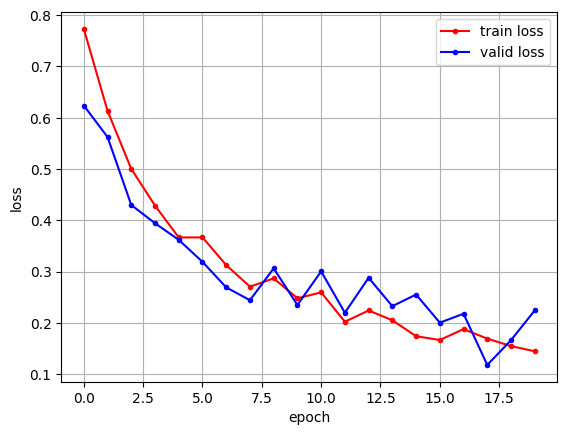

In [107]:
# 손실값 -> 학습이 계속되면 -> 0에 가까워 진다 -> 점점 정확해진다

# 손실값 회득
y_loss   = his.history['loss']
y_v_loss = his.history['val_loss']

# 차트 데코
x = np.arange( len(y_loss) )
plt.plot( x, y_loss,   marker='.', c='red',  label='train loss')
plt.plot( x, y_v_loss, marker='.', c='blue', label='valid loss')

# 차트 보인다
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
# 정확도에 반비례하여서 손실값을 0에 가까와 지고 있다(수렴한다)
# 좀더 많은 데이터로 더 많이 학습하면 더 좋은 성과가 예상된다.